In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import yaml
import tweepy
from textblob import TextBlob
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
import seaborn as sns

import os
import itertools
import collections
import nltk
from nltk.corpus import stopwords
import networkx

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Collecting tweets
We use tweepy which is built on Twitter API to collect tweets.

In [7]:
with open("config.yaml") as file:
    keys = yaml.safe_load(file)
    consumer_key = keys["search_tweets_api"]["consumer_key"]
    consumer_secret = keys["search_tweets_api"]["consumer_secret"]
    access_token = keys["search_tweets_api"]["access_token"]
    access_token_secret = keys["search_tweets_api"]["access_token_secret"]

In [24]:
def auth():
    try:
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)
    except:
        print("An error occurred during the authentication")
    return api

In [21]:
# function to remove URL
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

We note that Twitter’s search service is not meant to be an exhaustive source of Tweets. Not all Tweets will be indexed or made available via the search interface. Therefore, we focus on random sampling on users' sentiment. 

In [34]:
def search_by_hashtag(api, date_until, words):
    df = pd.DataFrame(columns=['id', 'created_at', 'username', 'location', 'following', 
                               'followers', 'retweetcount', 'text']) 
    tweets = tweepy.Cursor(api.search_tweets, q=words, lang="en", until=date_until, tweet_mode='extended').items() 
    list_tweets = [tweet for tweet in tweets] 
         
    for tweet in list_tweets: 
        id = tweet.id
        created_at = tweet.created_at
        username = tweet.user.screen_name 
        location = tweet.user.location 
        following = tweet.user.friends_count 
        followers = tweet.user.followers_count 
        totaltweets = tweet.user.statuses_count 
        retweetcount = tweet.retweet_count 

        try: 
            text = tweet.retweeted_status.full_text 
        except AttributeError: 
            text = tweet.full_text 
        text = remove_url(text)
  
        tweets = [id, created_at, username, location, following, 
                     followers, retweetcount, text] 

        df.loc[len(df)] = tweets 
          
    filename = 'tweets.csv'
    df.to_csv(filename)
    return df

In [36]:
api = auth()
words = "#UkraineRussia"
date_until = "2022-02-24"
search_by_hashtag(api, date_until, words)

Rate limit reached. Sleeping for: 3
Rate limit reached. Sleeping for: 851
Rate limit reached. Sleeping for: 851
Rate limit reached. Sleeping for: 850
Rate limit reached. Sleeping for: 853


# Sentiment Analysis
## Microsoft Azure’s Text Analytics
We adopt Cognitive Service to obtain the sentiment score of tweets. The API can ouput confidence scores of the text being postive, neutral and negative respectively. For consistency and easier understanding, we will map the scores into a composite score in range [-1. 1].

In [42]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    with open("config.yaml") as file:
        keys = yaml.safe_load(file)
        key = keys["azure"]["subscription_key"]
        endpoint = keys["azure"]["endpoint"]
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

In [65]:
# Function for detecting sentiment in text
def sentiment_analysis_example(client):

    documents = list(df["text"])
    polarity = []
    azure_class = []
    # For loop is used to bypass the batch request limit
    for document in documents:
        response = client.analyze_sentiment(documents=[document])[0]
        azure_class.append(response.sentiment)
        polarity.append(0 + response.confidence_scores.positive - response.confidence_scores.negative)
    df["azure_polar"] = polarity
    df["azure_class"] = azure_class

client = authenticate_client()      
sentiment_analysis_example(client)

## TextBlob
Textblob is an open-source python library for processing textual data. It can evaluate both polarity and subjectivity in text. The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [70]:
sentiment_objects = [TextBlob(tweet) for tweet in list(df['text'])]
blob_polar = [tweet.sentiment.polarity for tweet in sentiment_objects]
blob_subj = [tweet.sentiment.subjectivity for tweet in sentiment_objects]
df["blob_polar"] = blob_polar
df["blob_subj"] = blob_subj

# Analysis

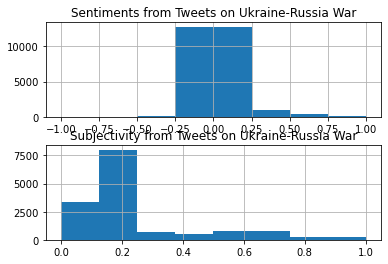

In [73]:
ax1 = plt.subplot(2, 1, 1)
df.hist(column="blob_polar", bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax1)
ax1.set_title("Sentiments from Tweets on Ukraine-Russia War")

ax2 = plt.subplot(2, 1, 2)
df.hist(column="blob_subj", bins=[0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], ax=ax2)
ax2.set_title("Subjectivity from Tweets on Ukraine-Russia War")
plt.show()

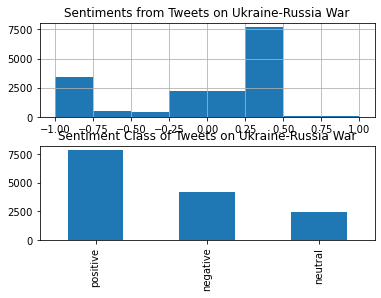

In [76]:
ax1 = plt.subplot(2, 1, 1)
df.hist(column="azure_polar", bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax1)
ax1.set_title("Sentiments from Tweets on Ukraine-Russia War")
ax2 = plt.subplot(2, 1, 2)
df['azure_class'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("Sentiment Class of Tweets on Ukraine-Russia War")
plt.show()